# Import

In [ ]:
from google.colab import drive

drive.mount('/content/drive')
path = '/content/drive/MyDrive/TTKS 20203/VIB/Track 1 Datarathon/'
%cd $path
!ls

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
/content/drive/MyDrive/TTKS 20203/VIB/Track 1 Datarathon
'0.Data VIB Hackathon Guidline.xlsx'   4.Data_Deposit.csv
 1.Data_Customer.csv		       5.Data_Lending.csv
 2.Data_MyVIB_Transaction.csv	       6.Data_Card.csv
 3.Data_MyVIB_Activity.csv	       label_times.csv
 3.Data_MyVIB_Activity_New


In [ ]:
import numpy as np
import pandas as pd
import seaborn as sns
from datetime import datetime
import matplotlib.pyplot as plt

sns.set()

In [ ]:
df_1 = pd.read_csv(path + '1.Data_Customer.csv',
                        parse_dates=['CLIENT_CREATE_DATE', 'DATE_OF_BIRTH', 'IB_REGISTER_DATE'], 
                        infer_datetime_format = True, 
                        dtype = {'CLIENT_SEX': 'category', 'STAFF_VIB': 'category', 'EB_REGISTER_CHANNEL': 'category', 'SMS': 'category', 'VERIFY_METHOD': 'category'})

df_2 = pd.read_csv(path + '2.Data_MyVIB_Transaction.csv',
                        parse_dates=['TRANS_DATE'],
                        infer_datetime_format = True,
                        dtype = {'TRXN_LV1': 'category', 'TRXN_LV2': 'category', 'DAY_OF_WEEK': 'category', 'TRANS_HOUR': 'category'})

df_3 = pd.read_csv(path + '3.Data_MyVIB_Activity.csv',
                        parse_dates=['ACTIVITY_DATE'],
                        infer_datetime_format = True,
                        dtype = {'DAY_OF_WEEK': 'category', 'ACTIVITY_HOUR': 'category', 'ACTIVITY_NAME': 'category'})

df_4 = pd.read_csv(path + '4.Data_Deposit.csv',
                        parse_dates=['MONTH'],
                        infer_datetime_format = True)

df_5 = pd.read_csv(path + '5.Data_Lending.csv',
                        parse_dates=['MONTH'],
                        infer_datetime_format = True)

df_6 = pd.read_csv(path + '6.Data_Card.csv',
                        parse_dates=['MONTH'],
                        infer_datetime_format = True)

In [ ]:
df_3.head()
df_3.sort_values(['CUSTOMER_NUMBER', 'ACTIVITY_DATE'])

,ACTIVITY_DATE,DAY_OF_WEEK,ACTIVITY_HOUR,ACTIVITY_NO,CUSTOMER_NUMBER,ACTIVITY_NAME
1959809,2019-09-26,Thu,9,3,0,MB_INTEREST_RATE_VIEW
5424961,2019-09-26,Thu,9,1,0,LOGIN
8159533,2019-09-26,Thu,9,1,0,QUERY_ACCOUNT_INFORMATION
12593509,2019-09-26,Thu,9,1,0,LOGOUT
13269743,2019-09-26,Thu,9,1,0,MB_SET_PIN
...,...,...,...,...,...,...
8307411,2019-12-31,Tue,19,1,999996,QUERY_ACCOUNT_INFORMATION
9610288,2019-12-31,Tue,19,1,999996,TRANSACTION_OVERVIEW_QUERY
12784900,2019-12-31,Tue,23,1,999996,LOGOUT
12784901,2019-12-31,Tue,19,1,999996,LOGOUT


# Predict Engineering

## Churn for One Customer

In [ ]:
def label_customer(customer_id, customer_activities, prediction_date, churn_days, 
                   lead_time = 1, prediction_window = 1, return_trans = False):
    
    """
    Make label times for a single customer. Returns a dataframe of labels with times, the binary label, 
    and the number of days until the next churn.
       
    Params
    --------
        customer_id (str): unique id for the customer
        customer_activities (dataframe): activities dataframe for the customer
        prediction_date (str): time at which predictions are made. Either "MS" for the first of the month
                               or "SMS" for the first and fifteenth of each month (Offset aliases of Pandas)
        churn_days (int): integer number of days without an active membership required for a churn. A churn is
                          defined by exceeding this number of days without an active membership.
        lead_time (int): number of periods in advance to make predictions for. Defaults to 1 (preditions for one offset)
        prediction_window(int): number of periods over which to consider churn. Defaults to 1.
        return_trans (boolean): whether or not to return the activities for analysis. Defaults to False.
        
    Return
    --------
        label_times (dataframe): a table of customer id, the cutoff times at the specified frequency, the 
                                 label for each cutoff time, the number of days until the next churn for each
                                 cutoff time, and the date on which the churn itself occurred.
        activities (dataframe): [optional] dataframe of customer activities if return_trans = True. Useful
                                  for making sure that the function performed as expected
    
    """

    # Don't modify original
    activities = customer_activities.copy()
    
    # Make sure to sort chronalogically
    activities['ACTIVITY_DATE'] = pd.to_datetime(activities['ACTIVITY_DATE'])
    activities.sort_values(['ACTIVITY_DATE'], inplace = True)

    # Create next activity date by shifting back one activity
    activities['next_activity_date'] = activities['ACTIVITY_DATE'].shift(-1)

    # Find number of days between current activity and next activity
    activities['difference_days'] = (activities['next_activity_date'] - activities['ACTIVITY_DATE']).dt.days
    
    # Determine which activities are associated with a churn
    activities['churn'] = activities['difference_days'] > churn_days
    
    # Find date of each churn
    activities.loc[activities['churn'] == True, 
                     'churn_date'] = activities.loc[activities['churn'] == True, 
                                                      'ACTIVITY_DATE'] + pd.Timedelta(churn_days + 1, 'd')
    
    # Range for cutoff times is from first to (last + 1 month) activity
    first_activity = activities['ACTIVITY_DATE'].min()
    last_activity = activities['ACTIVITY_DATE'].max()
    start_date = datetime(first_activity.year, first_activity.month, 1)
    
    # Handle December
    if last_activity.month == 12:
        end_date = datetime(last_activity.year + 1, 1, 1)
    else:
        end_date = datetime(last_activity.year, last_activity.month + 1, 1)
    
    # Make label times dataframe with cutoff times corresponding to prediction date
    label_times = pd.DataFrame({'cutoff_time': pd.date_range(start_date, end_date, freq = prediction_date),
                                'customer_number': customer_id
                               })
    # Use the lead time and prediction window parameters to establish the prediction window 
    # Prediction window is for each cutoff time
    label_times['prediction_window_start'] = label_times['cutoff_time'].shift(-lead_time)
    label_times['prediction_window_end'] = label_times['cutoff_time'].shift(-(lead_time + prediction_window))
    
    previous_churn_date = None

    # Iterate through every cutoff time
    for i, row in label_times.iterrows():
        
        # Default values if unknown
        churn_date = pd.NaT
        label = np.nan
        # Find the window start and end
        window_start = row['prediction_window_start']
        window_end = row['prediction_window_end']
        # Determine if there were any churns during the prediction window
        churns = activities.loc[(activities['churn_date'] >= window_start) & 
                                  (activities['churn_date'] < window_end), 'churn_date']

        # Positive label if there was a churn during window
        if not churns.empty:
            label = 1
            churn_date = churns.values[0]

            # Find number of days until next churn by 
            # subsetting to cutoff times before current churn and after previous churns
            if not previous_churn_date:
                before_idx = label_times.loc[(label_times['cutoff_time'] <= churn_date)].index
            else:
                before_idx = label_times.loc[(label_times['cutoff_time'] <= churn_date) & 
                                             (label_times['cutoff_time'] > previous_churn_date)].index

            # Calculate days to next churn for cutoff times before current churn
            label_times.loc[before_idx, 'days_to_churn'] = (churn_date - label_times.loc[before_idx, 
                                                                                         'cutoff_time']).dt.days
            previous_churn_date = churn_date

        else:
            label = 0

            # # Find activities before the end of the window that were not cancelled
            # activities_before = activities.loc[(activities['ACTIVITY_DATE'] < window_end) & 
            #                                        (activities['is_cancel'] == False)].copy()
            # # If the membership expiration date for this membership is after the window start, the custom has not churned
            # if np.any(activities_before['membership_expire_date'] >= window_start):
            #     label = 0

        # Assign values
        label_times.loc[i, 'label'] = label
        label_times.loc[i, 'churn_date'] = churn_date
        
        # Handle case with no churns
        if not np.any(label_times['label'] == 1):
            label_times['days_to_churn'] = np.nan
            label_times['churn_date'] = pd.NaT
        
    if return_trans:
        return label_times.drop(columns = ['customer_number']), activities
    
    return label_times[['customer_number', 'cutoff_time', 'label', 'days_to_churn', 'churn_date']].copy()

### MS

In [ ]:
CUSTOMER_ID = 0
customer_activities = df_3.loc[df_3['CUSTOMER_NUMBER'] == CUSTOMER_ID].copy()

label_times, cust_activities = label_customer(CUSTOMER_ID, customer_activities, 
                                                prediction_date = 'MS', churn_days = 31, 
                                                lead_time = 1, prediction_window = 1, return_trans = True)
label_times

,cutoff_time,prediction_window_start,prediction_window_end,label,churn_date,days_to_churn
0,2019-09-01,2019-10-01,2019-11-01,0.0,NaT,NaN
1,2019-10-01,2019-11-01,2019-12-01,0.0,NaT,NaN
2,2019-11-01,2019-12-01,2020-01-01,0.0,NaT,NaN
3,2019-12-01,2020-01-01,NaT,0.0,NaT,NaN
4,2020-01-01,NaT,NaT,0.0,NaT,NaN


In [ ]:
label_times[label_times['label'] == 1]

,cutoff_time,prediction_window_start,prediction_window_end,label,churn_date,days_to_churn
1,2019-10-01,2019-11-01,2019-12-01,1.0,2019-11-15,45.0


In [ ]:
cust_activities

,ACTIVITY_DATE,DAY_OF_WEEK,ACTIVITY_HOUR,ACTIVITY_NO,CUSTOMER_NUMBER,ACTIVITY_NAME,next_activity_date,difference_days,churn,churn_date
1959809,2019-09-26,Thu,9,3,0,MB_INTEREST_RATE_VIEW,2019-09-26,0.0,False,NaT
14038547,2019-09-26,Thu,9,1,0,TRANSFER_VIA_SML,2019-09-26,0.0,False,NaT
13418386,2019-09-26,Thu,9,2,0,AUTHENTICATION,2019-09-26,0.0,False,NaT
13269743,2019-09-26,Thu,9,1,0,MB_SET_PIN,2019-09-26,0.0,False,NaT
12593509,2019-09-26,Thu,9,1,0,LOGOUT,2019-09-26,0.0,False,NaT
...,...,...,...,...,...,...,...,...,...,...
12593520,2019-12-29,Sun,19,1,0,LOGOUT,2019-12-29,0.0,False,NaT
8159539,2019-12-29,Sun,19,1,0,QUERY_ACCOUNT_INFORMATION,2019-12-29,0.0,False,NaT
1959814,2019-12-29,Sun,19,2,0,MB_INTEREST_RATE_VIEW,2019-12-29,0.0,False,NaT
5424975,2019-12-29,Sun,19,2,0,LOGIN,2019-12-29,0.0,False,NaT


In [ ]:
cust_activities[cust_activities['churn'] == True]

,ACTIVITY_DATE,DAY_OF_WEEK,ACTIVITY_HOUR,ACTIVITY_NO,CUSTOMER_NUMBER,ACTIVITY_NAME,next_activity_date,difference_days,churn,churn_date
1959811,2019-10-14,Mon,8,2,0,MB_INTEREST_RATE_VIEW,2019-11-29,46.0,True,2019-11-15


### SMS

In [ ]:
label_times, customer_activities = label_customer(CUSTOMER_ID, customer_activities, 
                                                prediction_date = 'SMS', churn_days = 14, 
                                                lead_time = 1, prediction_window = 1, return_trans = True)
label_times

,cutoff_time,prediction_window_start,prediction_window_end,label,churn_date,days_to_churn
0,2019-09-01,2019-09-15,2019-10-01,0.0,NaT,58.0
1,2019-09-15,2019-10-01,2019-10-15,0.0,NaT,44.0
2,2019-10-01,2019-10-15,2019-11-01,1.0,2019-10-29,28.0
3,2019-10-15,2019-11-01,2019-11-15,0.0,NaT,14.0
4,2019-11-01,2019-11-15,2019-12-01,0.0,NaT,48.0
5,2019-11-15,2019-12-01,2019-12-15,0.0,NaT,34.0
6,2019-12-01,2019-12-15,2020-01-01,1.0,2019-12-19,18.0
7,2019-12-15,2020-01-01,NaT,0.0,NaT,4.0
8,2020-01-01,NaT,NaT,0.0,NaT,NaN


In [ ]:
label_times[label_times['label'] == 1]

,cutoff_time,prediction_window_start,prediction_window_end,label,churn_date,days_to_churn
2,2019-10-01,2019-10-15,2019-11-01,1.0,2019-10-29,28.0
6,2019-12-01,2019-12-15,2020-01-01,1.0,2019-12-19,18.0


In [ ]:
cust_activities

,ACTIVITY_DATE,DAY_OF_WEEK,ACTIVITY_HOUR,ACTIVITY_NO,CUSTOMER_NUMBER,ACTIVITY_NAME,next_activity_date,difference_days,churn,churn_date
1959809,2019-09-26,Thu,9,3,0,MB_INTEREST_RATE_VIEW,2019-09-26,0.0,False,NaT
14038547,2019-09-26,Thu,9,1,0,TRANSFER_VIA_SML,2019-09-26,0.0,False,NaT
13418386,2019-09-26,Thu,9,2,0,AUTHENTICATION,2019-09-26,0.0,False,NaT
13269743,2019-09-26,Thu,9,1,0,MB_SET_PIN,2019-09-26,0.0,False,NaT
12593509,2019-09-26,Thu,9,1,0,LOGOUT,2019-09-26,0.0,False,NaT
...,...,...,...,...,...,...,...,...,...,...
12593520,2019-12-29,Sun,19,1,0,LOGOUT,2019-12-29,0.0,False,NaT
8159539,2019-12-29,Sun,19,1,0,QUERY_ACCOUNT_INFORMATION,2019-12-29,0.0,False,NaT
1959814,2019-12-29,Sun,19,2,0,MB_INTEREST_RATE_VIEW,2019-12-29,0.0,False,NaT
5424975,2019-12-29,Sun,19,2,0,LOGIN,2019-12-29,0.0,False,NaT


In [ ]:
cust_activities[cust_activities['churn'] == True]

,ACTIVITY_DATE,DAY_OF_WEEK,ACTIVITY_HOUR,ACTIVITY_NO,CUSTOMER_NUMBER,ACTIVITY_NAME,next_activity_date,difference_days,churn,churn_date
1959811,2019-10-14,Mon,8,2,0,MB_INTEREST_RATE_VIEW,2019-11-29,46.0,True,2019-11-15


## Churn for All Customer

In [ ]:
lb = pd.read_csv('label_times.csv')
lb

,Unnamed: 0,customer_number,cutoff_time,label,days_to_churn,churn_date
0,0,0,2019-09-01,0.0,74.0,NaN
1,1,0,2019-10-01,1.0,44.0,2019-11-14
2,2,0,2019-11-01,0.0,13.0,NaN
3,3,0,2019-12-01,0.0,NaN,NaN
4,4,0,2020-01-01,0.0,NaN,NaN
...,...,...,...,...,...,...
423389,6,999982,2020-01-01,0.0,NaN,NaN
423390,0,999996,2019-10-01,0.0,91.0,NaN
423391,1,999996,2019-11-01,1.0,60.0,2019-12-31
423392,2,999996,2019-12-01,0.0,30.0,NaN


In [ ]:
pd.to_datetime(lb['cutoff_time'])

0        2019-09-01
1        2019-10-01
2        2019-11-01
3        2019-12-01
4        2020-01-01
            ...    
423389   2020-01-01
423390   2019-10-01
423391   2019-11-01
423392   2019-12-01
423393   2020-01-01
Name: cutoff_time, Length: 423394, dtype: datetime64[ns]

In [ ]:
lb=lb.sort_values(by=["cutoff_time"])
lb

,Unnamed: 0,customer_number,cutoff_time,label,days_to_churn,churn_date
60922,0,144977,2019-01-01,0.0,164.0,NaN
380391,0,899548,2019-01-01,0.0,84.0,NaN
411991,0,974253,2019-01-01,0.0,199.0,NaN
65475,0,155753,2019-01-01,0.0,201.0,NaN
211678,0,502573,2019-01-01,0.0,NaN,NaN
...,...,...,...,...,...,...
16358,5,37920,2020-01-01,0.0,NaN,NaN
3333,5,7797,2020-01-01,0.0,NaN,NaN
255704,4,604452,2020-01-01,0.0,NaN,NaN
84239,5,199849,2020-01-01,0.0,NaN,NaN


In [ ]:
a = lb['cutoff_time'].unique()
a

array(['2019-01-01', '2019-02-01', '2019-03-01', '2019-04-01',
       '2019-05-01', '2019-06-01', '2019-07-01', '2019-08-01',
       '2019-09-01', '2019-10-01', '2019-11-01', '2019-12-01',
       '2020-01-01'], dtype=object)

2019-01-01 14.312198739340008
2019-02-01 12.754577247479942
2019-03-01 12.632078831770153
2019-04-01 10.422491456974216
2019-05-01 12.047346232839693
2019-06-01 56.93397918909221
2019-07-01 4.747385215387343
2019-08-01 9.260126111738304
2019-09-01 8.726015323072751
2019-10-01 7.458236100307442
2019-11-01 4.320304618088326
2019-12-01 0
2020-01-01 0


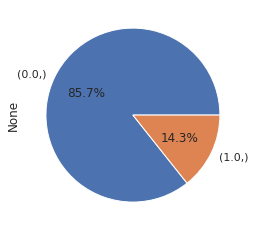

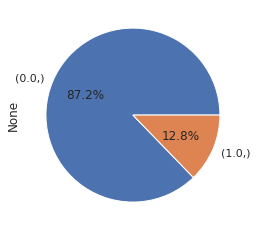

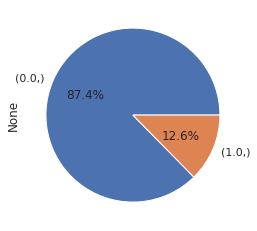

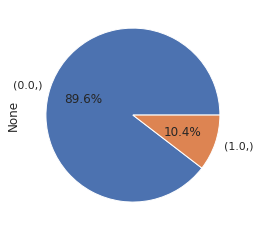

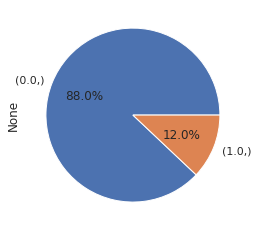

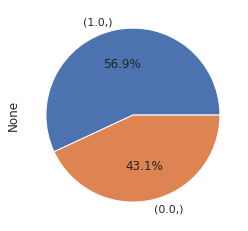

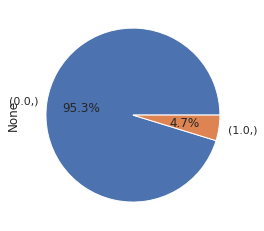

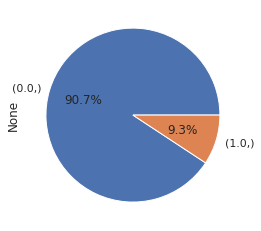

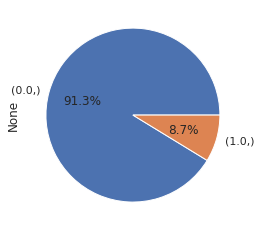

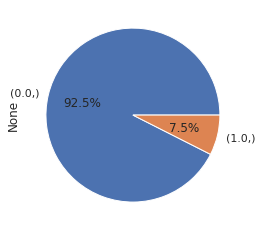

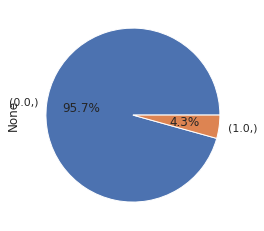

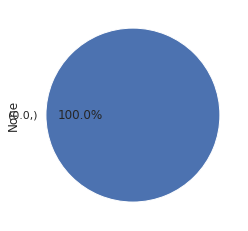

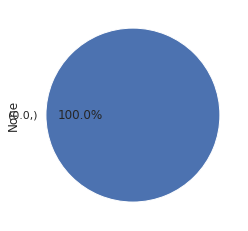

In [ ]:
for idx,i in enumerate(a):
    b = lb.loc[lb['cutoff_time'] == i, ['label']].value_counts()
    
    plt.figure(idx+1)
    b.plot(kind='pie', autopct='%1.1f%%')
    if len(b) == 1:
        churn_rate = 0
    else:
        churn_rate = b[1].item()*100/(b[1].item()+b[0].item())
    print(i,churn_rate)
# b.plot.bar(color = 'b')

In [ ]:
def make_label_times(activities, prediction_date, churn_days, lead_time = 1, prediction_window = 1,):
    """
    Make labels for an entire series of transactions. 
    
    Params
    --------
        transactions (dataframe): table of customer transactions
        prediction_date (str): time at which predictions are made. Either "MS" for the first of the month
                               or "SMS" for the first and fifteenth of each month 
        churn_days (int): integer number of days without an active membership required for a churn. A churn is
                          defined by exceeding this number of days without an active membership.
        lead_time (int): number of periods in advance to make predictions for. Defaults to 1 (preditions for one offset)
        prediction_window(int): number of periods over which to consider churn. Defaults to 1.
    Return
    --------
        label_times (dataframe): a table with customer ids, cutoff times, binary label, regression label, 
                                 and date of churn. This table can then be used for feature engineering.
    """
    
    label_times = []
    activities = activities.sort_values(['CUSTOMER_NUMBER', 'ACTIVITY_DATE'])
    
    # Iterate through each customer and find labels
    for customer_id, customer_activities in activities.groupby('CUSTOMER_NUMBER'):
        lt_cust = label_customer(customer_id, customer_activities,
                                    prediction_date, churn_days, 
                                    lead_time, prediction_window)
        
        label_times.append(lt_cust)
        
    # Concatenate into a single dataframe
    return pd.concat(label_times)

### MS

#### 30 days

In [ ]:
import time
start_time = time.time()

label_times = make_label_times(df_3, prediction_date = 'MS', churn_days = 30,
                               lead_time = 1, prediction_window = 1)

print("--- %s seconds ---" % (time.time() - start_time))

label_times.to_csv('label_times.csv')
label_times

--- 1899.8635623455048 seconds ---


,customer_number,cutoff_time,label,days_to_churn,churn_date
0,0,2019-09-01,0.0,74.0,NaT
1,0,2019-10-01,1.0,44.0,2019-11-14
2,0,2019-11-01,0.0,13.0,NaT
3,0,2019-12-01,0.0,NaN,NaT
4,0,2020-01-01,0.0,NaN,NaT
...,...,...,...,...,...
6,999982,2020-01-01,0.0,NaN,NaT
0,999996,2019-10-01,0.0,91.0,NaT
1,999996,2019-11-01,1.0,60.0,2019-12-31
2,999996,2019-12-01,0.0,30.0,NaT


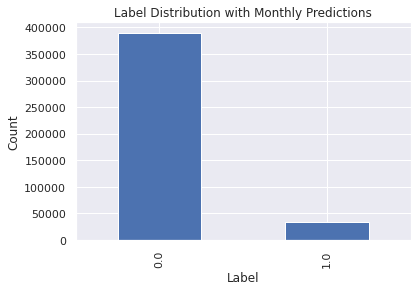

In [ ]:
label_times['label'].value_counts().plot.bar(color = 'b');
plt.xlabel('Label'); plt.ylabel('Count'); plt.title('Label Distribution with Monthly Predictions');

0.0    389814
1.0     33580
Name: label, dtype: int64

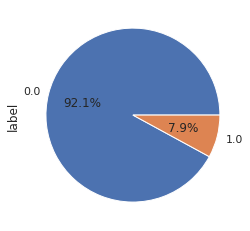

In [ ]:
churn_rate = label_times['label'].value_counts()
churn_rate.plot(kind='pie', autopct='%1.1f%%')
churn_rate

#### 60 days

In [ ]:
import time
start_time = time.time()

label_times_1 = make_label_times(df_3, prediction_date = 'MS', churn_days = 60,
                               lead_time = 1, prediction_window = 1)

print("--- %s seconds ---" % (time.time() - start_time))

label_times_1

--- 1885.8047604560852 seconds ---


,customer_number,cutoff_time,label,days_to_churn,churn_date
0,0,2019-09-01,0.0,NaN,NaT
1,0,2019-10-01,0.0,NaN,NaT
2,0,2019-11-01,0.0,NaN,NaT
3,0,2019-12-01,0.0,NaN,NaT
4,0,2020-01-01,0.0,NaN,NaT
...,...,...,...,...,...
6,999982,2020-01-01,0.0,NaN,NaT
0,999996,2019-10-01,0.0,NaN,NaT
1,999996,2019-11-01,0.0,NaN,NaT
2,999996,2019-12-01,0.0,NaN,NaT


0.0    420165
1.0      3229
Name: label, dtype: int64

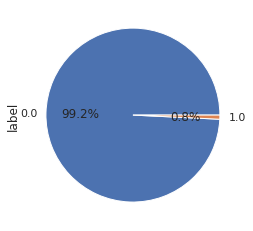

In [ ]:
churn_rate = label_times_1['label'].value_counts()
churn_rate.plot(kind='pie', autopct='%1.1f%%')
churn_rate

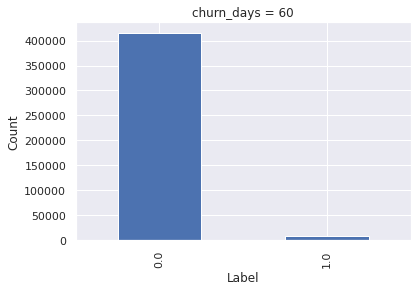

In [ ]:
label_times_1['label'].value_counts().plot.bar(color = 'b');
plt.xlabel('Label'); plt.ylabel('Count'); plt.title('churn_days = 60');

#### 90 days

In [ ]:
import time
start_time = time.time()

label_times_2 = make_label_times(df_3, prediction_date = 'MS', churn_days = 90,
                               lead_time = 1, prediction_window = 1)

print("--- %s seconds ---" % (time.time() - start_time))

label_times_2

--- 1880.3428785800934 seconds ---


,customer_number,cutoff_time,label,days_to_churn,churn_date
0,0,2019-09-01,0.0,NaN,NaT
1,0,2019-10-01,0.0,NaN,NaT
2,0,2019-11-01,0.0,NaN,NaT
3,0,2019-12-01,0.0,NaN,NaT
4,0,2020-01-01,0.0,NaN,NaT
...,...,...,...,...,...
6,999982,2020-01-01,0.0,NaN,NaT
0,999996,2019-10-01,0.0,NaN,NaT
1,999996,2019-11-01,0.0,NaN,NaT
2,999996,2019-12-01,0.0,NaN,NaT


0.0    420165
1.0      3229
Name: label, dtype: int64

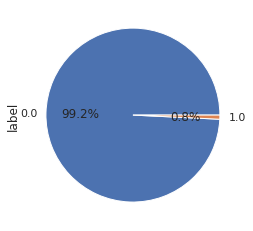

In [ ]:
churn_rate = label_times_2['label'].value_counts()
churn_rate.plot(kind='pie', autopct='%1.1f%%')
churn_rate

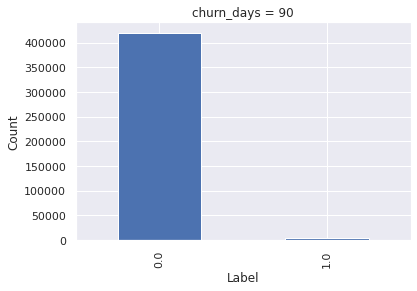

In [ ]:
label_times_2['label'].value_counts().plot.bar(color = 'b');
plt.xlabel('Label'); plt.ylabel('Count'); plt.title('churn_days = 90');

### SMS

In [ ]:
label_times = make_label_times(df_3.head(100), prediction_date = 'SMS', churn_days = 14,
                               lead_time = 1, prediction_window = 1)
label_times

,customer_number,cutoff_time,label,days_to_churn,churn_date
0,630178,2019-01-01,0.0,162.0,NaT
1,630178,2019-01-15,0.0,148.0,NaT
2,630178,2019-02-01,0.0,131.0,NaT
3,630178,2019-02-15,0.0,117.0,NaT
4,630178,2019-03-01,0.0,103.0,NaT
...,...,...,...,...,...
13,935065,2019-07-15,0.0,NaN,NaT
14,935065,2019-08-01,0.0,NaN,NaT
0,975426,2019-01-01,0.0,NaN,NaT
1,975426,2019-01-15,0.0,NaN,NaT


In [ ]:
label_times['label'].value_counts()

0.0    53
1.0    15
Name: label, dtype: int64

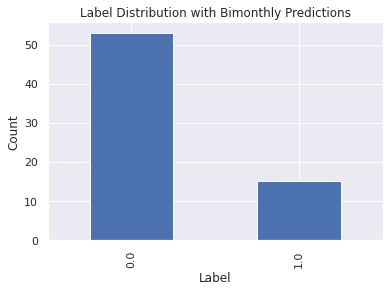

In [ ]:
label_times['label'].value_counts().plot.bar(color = 'b');
plt.xlabel('Label'); plt.ylabel('Count'); plt.title('Label Distribution with Bimonthly Predictions');

# Feature Engineering - Featuretools

In [ ]:
# %%capture
!pip install "featuretools[complete]"

     |████████████████████████████████| 329 kB 5.3 MB/s 
     |████████████████████████████████| 296 kB 45.1 MB/s 
     |████████████████████████████████| 596 kB 31.3 MB/s 
     |████████████████████████████████| 147 kB 50.4 MB/s 
     |████████████████████████████████| 1.0 MB 40.0 MB/s 
     |████████████████████████████████| 786 kB 65.3 MB/s 
     |████████████████████████████████| 11.3 MB 40.0 MB/s 
     |████████████████████████████████| 1.4 MB 32.7 MB/s 
     |████████████████████████████████| 281.3 MB 38 kB/s 
     |████████████████████████████████| 125 kB 59.1 MB/s 
     |████████████████████████████████| 198 kB 66.5 MB/s 
  Created wheel for pyspark: filename=pyspark-3.2.0-py2.py3-none-any.whl size=281805912 sha256=97bb09a10bee6e6b2016882b0667113748acd87a26888587634a46bbb409d865
  Stored in directory: /root/.cache/pip/wheels/0b/de/d2/9be5d59d7331c6c2a7c1b6d1a4f463ce107332b1ecd4e80718
Successfully built pyspark
  Attempting uninstall: pyyaml
    Found existing installation: PyYA

## Quick Start

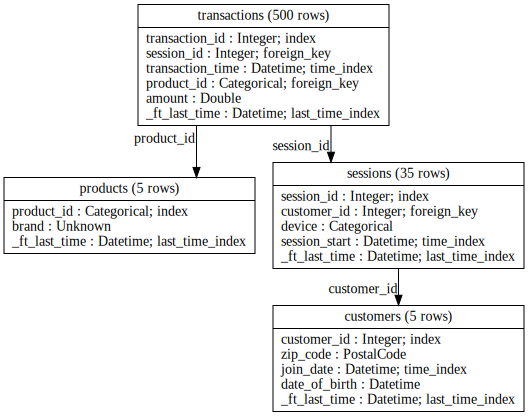

In [ ]:
import featuretools as ft
es = ft.demo.load_mock_customer(return_entityset=True)
es.plot()

In [ ]:
data = ft.demo.load_mock_customer()

In [ ]:
customers_df = data["customers"]

customers_df

,customer_id,zip_code,join_date,date_of_birth
0,1,60091,2011-04-17 10:48:33,1994-07-18
1,2,13244,2012-04-15 23:31:04,1986-08-18
2,3,13244,2011-08-13 15:42:34,2003-11-21
3,4,60091,2011-04-08 20:08:14,2006-08-15
4,5,60091,2010-07-17 05:27:50,1984-07-28


In [ ]:
sessions_df = data["sessions"]

sessions_df.sample(5)

,session_id,customer_id,device,session_start
13,14,1,tablet,2014-01-01 03:28:00
6,7,3,tablet,2014-01-01 01:39:40
1,2,5,mobile,2014-01-01 00:17:20
28,29,1,mobile,2014-01-01 07:10:05
24,25,3,desktop,2014-01-01 05:59:40


In [ ]:
transactions_df = data["transactions"]

transactions_df.sample(5)

,transaction_id,session_id,transaction_time,product_id,amount
74,232,5,2014-01-01 01:20:10,1,139.20
231,27,17,2014-01-01 04:10:15,2,90.79
434,36,31,2014-01-01 07:50:10,3,62.35
420,56,30,2014-01-01 07:35:00,3,72.70
54,444,4,2014-01-01 00:58:30,4,43.59


In [ ]:
entities = {
   "customers" : (customers_df, "customer_id"),
   "sessions" : (sessions_df, "session_id", "session_start"),
   "transactions" : (transactions_df, "transaction_id", "transaction_time")}

In [ ]:
relationships = [("sessions", "session_id", "transactions", "session_id"),
                     ("customers", "customer_id", "sessions", "customer_id")]

In [ ]:
feature_matrix_customers, features_defs = ft.dfs(entities=entities,
                                                     relationships=relationships,
                                                     target_entity="customers")
    

feature_matrix_customers

TypeError: ignored

In [ ]:
feature = features_defs[18]
feature

NameError: ignored

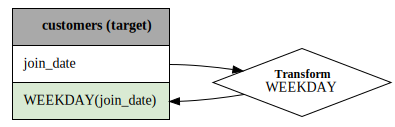

In [ ]:
ft.graph_feature(feature)

In [ ]:
ft.describe_feature(feature)

'The day of the week of the "join_date".'

## Featuretools

In [ ]:
label_times = pd.read_csv(path + 'label_times.csv')
cutoff_times = label_times.drop(label_times.columns[[0]], axis = 1)
cutoff_times.rename(columns={'customer_number': 'CUSTOMER_NUMBER'}, inplace=True)
cutoff_times

,CUSTOMER_NUMBER,cutoff_time,label,days_to_churn,churn_date
0,0,2019-09-01,0.0,74.0,NaN
1,0,2019-10-01,1.0,44.0,2019-11-14
2,0,2019-11-01,0.0,13.0,NaN
3,0,2019-12-01,0.0,NaN,NaN
4,0,2020-01-01,0.0,NaN,NaN
...,...,...,...,...,...
423389,999982,2020-01-01,0.0,NaN,NaN
423390,999996,2019-10-01,0.0,91.0,NaN
423391,999996,2019-11-01,1.0,60.0,2019-12-31
423392,999996,2019-12-01,0.0,30.0,NaN


In [ ]:
import featuretools as ft
import featuretools.variable_types as vtypes

# Make empty entityset
es = ft.EntitySet(id = 'customers')

In [ ]:
# Create entity from df_1
es.entity_from_dataframe(entity_id='df_1', dataframe=df_1,
                         index = 'CUSTOMER_NUMBER',
                         time_index = ['CLIENT_CREATE_DATE','IB_REGISTER_DATE'],
                         variable_types = {'CLIENT_SEX': vtypes.Categorical,
                                           'STAFF_VIB': vtypes.Categorical,
                                           'EB_REGISTER_CHANNEL': vtypes.Categorical,
                                           'SMS': vtypes.Categorical,
                                           'VERIFY_METHOD': vtypes.Categorical})

TypeError: ignored

In [ ]:
# Create entity from df_2
es.entity_from_dataframe(entity_id='df_2', dataframe=df_2,
                         index = 'CUSTOMER_NUMBER',
                         time_index = 'TRANS_DATE',
                         variable_types = {'TRAN_LV1': vtypes.Categorical,
                                           'TRAN_LV2': vtypes.Categorical,
                                           'DAY_OF_WEEK': vtypes.Categorical,
                                           'TRANS_HOUR': vtypes.Categorical})

LookupError: ignored

In [ ]:
# Create entity from df_3
es.entity_from_dataframe(entity_id='df_3', dataframe=df_3,
                         index = 'CUSTOMER_NUMBER',
                         time_index = 'ACTIVITY_DATE',
                         variable_types = {'DAY_OF_WEEK': vtypes.Categorical,
                                           'ACTIVITY_HOUR': vtypes.Categorical,
                                           'ACTIVITY_NAME': vtypes.Categorical,})

AssertionError: ignored

In [ ]:
# Create entity from df_4
es.entity_from_dataframe(entity_id='df_4', dataframe=df_4,
                         index = 'CUSTOMER_NUMBER',
                         time_index = 'MONTH')

AssertionError: ignored

In [ ]:
# Create entity from df_5
es.entity_from_dataframe(entity_id='df_6', dataframe=df_6,
                         index = 'CUSTOMER_NUMBER',
                         time_index = 'MONTH')

AssertionError: ignored

In [ ]:
# Create entity from df_6
es.entity_from_dataframe(entity_id='df_6', dataframe=df_6,
                         index = 'CUSTOMER_NUMBER',
                         time_index = 'MONTH')

AssertionError: ignored

In [ ]:
# Relationships (parent, child)
r_member_df_2 = ft.Relationship(es['df_1']['CUSTOMER_NUMBER'], es['df_2']['CUSTOMER_NUMBER'])
r_member_df_3 = ft.Relationship(es['df_1']['CUSTOMER_NUMBER'], es['df_3']['CUSTOMER_NUMBER'])
r_member_df_4 = ft.Relationship(es['df_1']['CUSTOMER_NUMBER'], es['df_4']['CUSTOMER_NUMBER'])
r_member_df_5 = ft.Relationship(es['df_1']['CUSTOMER_NUMBER'], es['df_5']['CUSTOMER_NUMBER'])
r_member_df_6 = ft.Relationship(es['df_1']['CUSTOMER_NUMBER'], es['df_6']['CUSTOMER_NUMBER'])

es.add_relationships([r_member_df_2, r_member_df_3, r_member_df_4, r_member_df_5, r_member_df_6])

KeyError: ignored

In [ ]:
from timeit import default_timer as timer

agg_primitives = ['sum', 'time_since_last', 'avg_time_between', 'all', 'mode', 'num_unique', 'min', 'last', 
                  'mean', 'percent_true', 'max', 'std', 'count']

trans_primitives = ['weekend', 'cum_sum', 'day', 'month', 'diff', 'time_since_previous']

where_primitives = ['sum', 'mean', 'percent_true', 'all', 'any']

start = timer()
feature_matrix, feature_defs = ft.dfs(entityset=es, target_entity='df_1', 
                                      cutoff_time = cutoff_times, 
                                      agg_primitives = agg_primitives,
                                      trans_primitives = trans_primitives,
                                      where_primitives = where_primitives,
                                      max_depth = 2, features_only = False,
                                      verbose = 1, chunk_size = 1000,  
                                      n_jobs = -1,
                                      cutoff_time_in_index = True)
end = timer()
print(f'{round(end - start)} seconds elapsed.')

KeyError: ignored

In [ ]:
feature_matrix.head()

NameError: ignored